# SET the Image Resolution

In [1]:
from helper import IMAGE_RES

# SET the no of Images to Be Trained

In [2]:
LIMIT = 150

# Import Libraries

In [3]:
import os
import cv2
import time
import json
import keras
import tensorflow
import numpy as np
import seaborn as sns
from PIL import Image
import mediapipe as mp
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from helper import build_directory_lookup, get_subdirectory
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Data Load 

In [4]:
# training

# define the subdirectory where you training data is located
training_sub = "data/asl_alphabet_train"
testing_sub = "data/asl_alphabet_test"

training_path = get_subdirectory(training_sub)
directory_lookup, directory_reverse_lookup = build_directory_lookup(training_path)

file_name = "directory_reverse_lookup.json"

# Save the dictionary to a JSON file
with open(file_name, "w") as json_file:
    json.dump(directory_reverse_lookup, json_file)


print(directory_lookup)
print("--------------------------")
print(directory_reverse_lookup)

Current Directory: c:\Users\navee\Projects\ASL-Fingerspelling-Recognition
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'del': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'nothing': 15, 'O': 16, 'P': 17, 'Q': 18, 'R': 19, 'S': 20, 'space': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28}
--------------------------
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'del', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'nothing', 16: 'O', 17: 'P', 18: 'Q', 19: 'R', 20: 'S', 21: 'space', 22: 'T', 23: 'U', 24: 'V', 25: 'W', 26: 'X', 27: 'Y', 28: 'Z'}


In [5]:
# training


# Images in x_train
x_train = []
# Labels in y_train
y_train = []
datacount = 0
for i in range(0, len(directory_lookup.keys())):
    class_directory = os.path.join(training_path, directory_reverse_lookup[i])
    limit_count = 0
    for j in os.listdir(class_directory):
        if limit_count <= LIMIT:
            limit_count += 1
        else:
            limit_count = 0
            break
        if not j.startswith("."):
            count = 0
            img = Image.open(os.path.join(class_directory, j)).convert("RGB")
            img = img.resize((IMAGE_RES, IMAGE_RES))
            arr = np.array(img)
            x_train.append(arr)
            count = count + 1
            y_values_t = np.full(
                (count, 1), directory_lookup[directory_reverse_lookup[i]]
            )
            y_train.append(y_values_t)
            datacount = datacount + count
x_train: np = np.array(x_train, dtype="float32")
y_train: np = np.array(y_train)
y_train: np = y_train.reshape(datacount)

# Data Split

In [6]:
# split the data into train , validation/ test 7:3 split respectively
x_train, x_valid_test, y_train, y_valid_test = train_test_split(
    x_train, y_train, test_size=0.3, random_state=42
)

# Split the combined validation/testing set into validation and testing sets 8:2 split respectively
x_validation, x_test, y_validation, y_test = train_test_split(
    x_valid_test, y_valid_test, test_size=0.2, random_state=42
)

# Print the shapes to verify the split
print("Training data shapes:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

print("Validation data shapes:")
print("x_validation shape:", x_validation.shape)
print("y_validation shape:", y_validation.shape)

print("Testing data shapes:")
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

Training data shapes:
x_train shape: (3065, 150, 150, 3)
y_train shape: (3065,)
Validation data shapes:
x_validation shape: (1051, 150, 150, 3)
y_validation shape: (1051,)
Testing data shapes:
x_test shape: (263, 150, 150, 3)
y_test shape: (263,)


In [7]:
# training
y_train: np = to_categorical(y_train)
x_train: np = x_train / 255
x_train: np = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# validation
y_validation: np = to_categorical(y_validation)
x_validation: np = x_validation / 255
x_validation: np = x_validation.reshape(
    (x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 3)
)

# test
y_test: np = to_categorical(y_test)
x_test: np = x_test / 255
x_test: np = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))

In [8]:
x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((3065, 150, 150, 3),
 (3065, 29),
 (1051, 150, 150, 3),
 (1051, 29),
 (263, 150, 150, 3),
 (263, 29))

In [9]:
num_classes = len(directory_lookup.keys())

model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_RES, IMAGE_RES, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [10]:
# Train the model
epochs = 10  # You can adjust the number of epochs
batch_size = 12  # You can adjust the batch size

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_validation, y_validation),
)

Epoch 1/10
256/256 [==============================] - 46s 175ms/step - loss: 2.9948 - accuracy: 0.1772 - val_loss: 1.7313 - val_accuracy: 0.4681
Epoch 2/10
256/256 [==============================] - 44s 174ms/step - loss: 1.5355 - accuracy: 0.5533 - val_loss: 0.6889 - val_accuracy: 0.8240
Epoch 3/10
256/256 [==============================] - 44s 171ms/step - loss: 0.7832 - accuracy: 0.7674 - val_loss: 0.4093 - val_accuracy: 0.9029
Epoch 4/10
256/256 [==============================] - 44s 171ms/step - loss: 0.5119 - accuracy: 0.8467 - val_loss: 0.2627 - val_accuracy: 0.9343
Epoch 5/10
256/256 [==============================] - 44s 171ms/step - loss: 0.3479 - accuracy: 0.8936 - val_loss: 0.2660 - val_accuracy: 0.9277
Epoch 6/10
256/256 [==============================] - 44s 171ms/step - loss: 0.2697 - accuracy: 0.9217 - val_loss: 0.2698 - val_accuracy: 0.9267
Epoch 7/10
256/256 [==============================] - 44s 171ms/step - loss: 0.2138 - accuracy: 0.9315 - val_loss: 0.1800 - val_ac

In [11]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

9/9 [==============================] - 0s 47ms/step - loss: 0.3273 - accuracy: 0.9506
Test accuracy: 95.06%


In [12]:
model.save_weights("model_weights.h5")

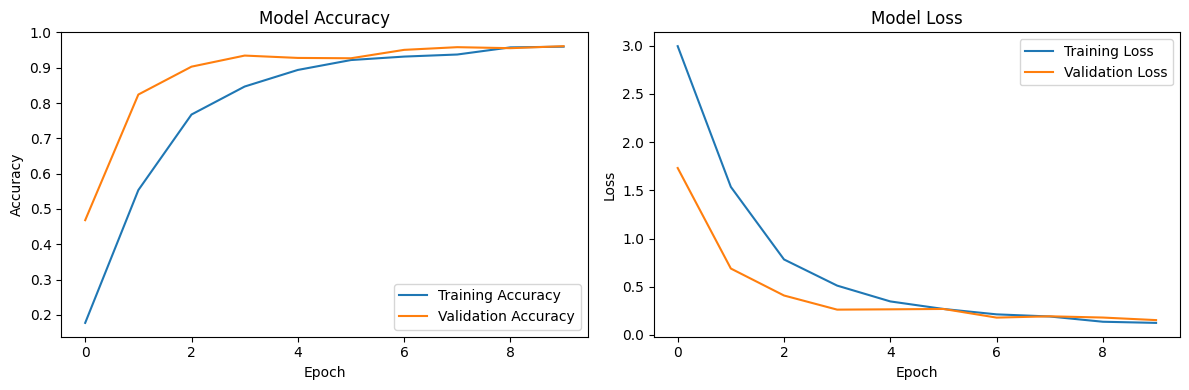

In [13]:
# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
axes[0].plot(history.history["accuracy"], label="Training Accuracy")
axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="lower right")

# Plot training & validation loss
axes[1].plot(history.history["loss"], label="Training Loss")
axes[1].plot(history.history["val_loss"], label="Validation Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend(loc="upper right")

# Ensure proper layout and show the plots
plt.tight_layout()
plt.show()

9/9 [==============================] - 0s 44ms/step


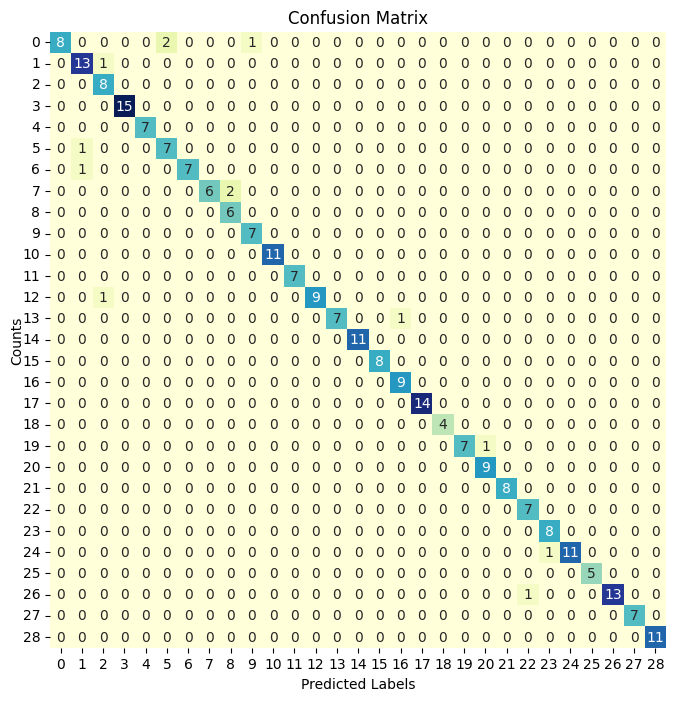

In [14]:
test_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pred, axis=1)

# Create a confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Create a heatmap with Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", cbar=False, square=True)

# Set labels and titles
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Customize the color bar (optional)
cax = plt.gcf().axes[-1]
cax.set_yticklabels(cax.get_yticklabels(), rotation=0)
cax.set_ylabel("Counts", rotation=90, va="center")

plt.show()